Histogram equalization before OpenPose. Then Openpose without background videos as input

In [1]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
PATH = f"../../../datasets/openpose_processed/hist_eq/{'' if BACKGROUND else 'no_'}back"

In [2]:
import tensorflow as tf

In [3]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[1:], 'GPU')

2022-05-05 17:08:12.550285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.551627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.552653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.558011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.559365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Set seed

In [4]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [5]:
import numpy as np
import cv2

In [6]:
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)
        labels[i] = video_labels[video_ID]

    return videos, labels

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [7]:
import gc
from tensorflow.keras import backend as K

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        bacth_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]

        return load_videos(bacth_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

## Videos to load

In [8]:
import glob

train_video_IDs = glob.glob(f"{PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10)

# ConvLSTM

In [9]:
inputs = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

2022-05-05 17:08:12.617211: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 17:08:12.763972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.765014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 17:08:12.765424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 100, 100, 3)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 98, 98, 32)        40448     
                                                                 
 depthwise_conv2d (Depthwise  (None, 96, 96, 64)       640       
 Conv2D)                                                         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                             

In [10]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2)

Epoch 1/30


2022-05-05 17:08:18.033118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-05-05 17:08:19.113295: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-05 17:08:19.115119: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2022-05-05 17:08:19.115148: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-05-05 17:08:19.115270: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

160/160 - 212s - loss: 0.6933 - accuracy: 0.5150 - val_loss: 0.6816 - val_accuracy: 0.6750 - 212s/epoch - 1s/step
Epoch 2/30
160/160 - 206s - loss: 0.5931 - accuracy: 0.7081 - val_loss: 0.5057 - val_accuracy: 0.7475 - 206s/epoch - 1s/step
Epoch 3/30
160/160 - 205s - loss: 0.5257 - accuracy: 0.7419 - val_loss: 0.4809 - val_accuracy: 0.7575 - 205s/epoch - 1s/step
Epoch 4/30
160/160 - 206s - loss: 0.5005 - accuracy: 0.7544 - val_loss: 0.4634 - val_accuracy: 0.7800 - 206s/epoch - 1s/step
Epoch 5/30
160/160 - 205s - loss: 0.4846 - accuracy: 0.7663 - val_loss: 0.4354 - val_accuracy: 0.7925 - 205s/epoch - 1s/step
Epoch 6/30
160/160 - 207s - loss: 0.4588 - accuracy: 0.7969 - val_loss: 0.4640 - val_accuracy: 0.7700 - 207s/epoch - 1s/step
Epoch 7/30
160/160 - 206s - loss: 0.4649 - accuracy: 0.7850 - val_loss: 0.4138 - val_accuracy: 0.8100 - 206s/epoch - 1s/step
Epoch 8/30
160/160 - 205s - loss: 0.4372 - accuracy: 0.8056 - val_loss: 0.4138 - val_accuracy: 0.7975 - 205s/epoch - 1s/step
Epoch 9/30


# Model performance

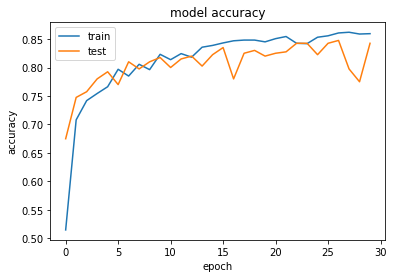

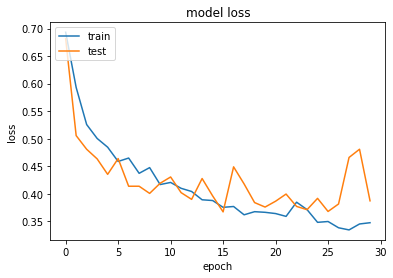

In [11]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save perfomance metrics

In [12]:
import os
import ipynbname
import json
from keras.utils.layer_utils import count_params

current_directory = os.getcwd() + '/'
results_directory = current_directory.replace('memo_notebooks', 'memo_results')

experiment_name = ipynbname.name()

# Save history as json
with open(results_directory + experiment_name + '.json', 'w') as f:
    json.dump(history.history, f)
    
# Compute max val_accuracy and number of trainable params and append to stats
max_val_acc = max(history.history['val_accuracy'])
trainable_params = count_params(model.trainable_weights)

# Store value in latex table format
acc_string = f'{experiment_name} & {max_val_acc:.2%}'.replace('%', '\%')
acc_params_string = acc_string + f' & {trainable_params}'

with open(results_directory + 'acc.dat', 'a') as f:
    f.write(acc_string + ' \\\ \n')
    
with open(results_directory + 'acc_params.dat', 'a') as f:
    f.write(acc_params_string + ' \\\ \n')